In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Traffic Flow 
![](../figures/traffic_flow_taxonomy.png)

In [15]:
def egrad(g):
  def wrapped(x, *rest):
    y, g_vjp = jax.vjp(lambda x: g(x, *rest), x)
    x_bar, = g_vjp(np.ones_like(y))
    return x_bar
  return wrapped

In [16]:
V_0 = 50/3.6 # Desired speed (km/h)
T = 1.2 # Time gap (s)
rho_max = 120*1e-3 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
print("rho_C:", rho_C)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho-1e-3, (1-rho/rho_max)/T))

dQ_e = egrad(Q_e)

rho_C: 0.04


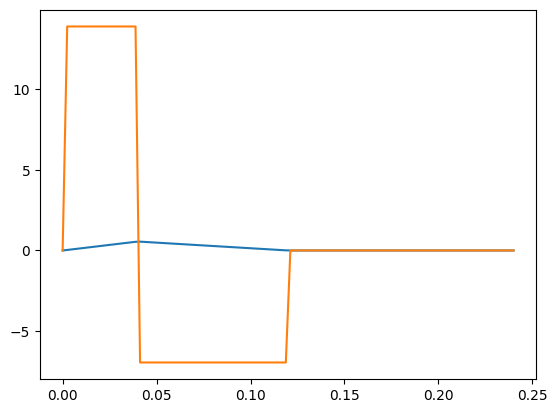

In [17]:
rho_linspace = np.linspace(0, 2*rho_max, 100)
plt.plot(rho_linspace, Q_e(rho_linspace))
plt.plot(rho_linspace, dQ_e(rho_linspace))

In [140]:
x_0, x_N = 0, 1000
N_x = 1001
T_sim = 50
N_t = 1000

dx = (x_N - x_0)/(N_x-1)
dt = T_sim/N_t

xs = jnp.linspace(x_0, x_N, N_x)
rho_0x = rho_max/4 + jnp.exp(-jnp.square((xs - x_N/2)/200))*rho_max/8
rho_t0 = rho_max/4 + jnp.zeros(N_t) 
rho_t1 = rho_max/4 + jnp.zeros(N_t) 

In [141]:
print("dx: ", dx, "\ndt: ", dt)
print("Courant-Friedrichs-Lévy condition (CFL condition) for LWR models: ", dt*max(V_0, l_eff/T)/dx)

dx:  1.0 
dt:  0.05
Courant-Friedrichs-Lévy condition (CFL condition) for LWR models:  0.6944444444444445


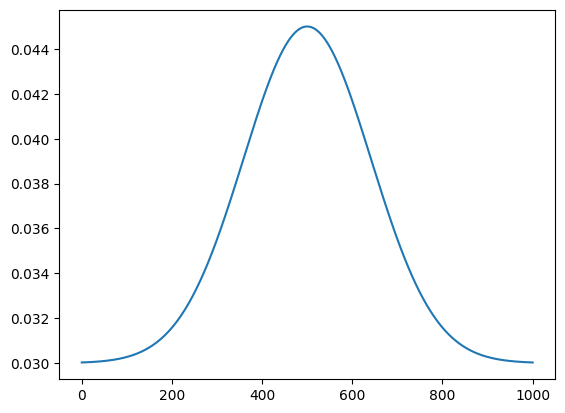

In [142]:
plt.plot(rho_0x)

# Method 1

$$
\frac{\rho_k (t_{i+1}) - \rho_k(t_i)}{\Delta t} + \frac{dQ_e(\rho_k(t_i))}{d\rho}\frac{\rho_{k+1}(t_i) - \rho_{k-1}(t_i)}{2\Delta x} = 0
$$

In [143]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    rho[t_i+1, 1:-1] = 0.5*(rho[t_i, 2:]+ rho[t_i, :-2]) - dt*dQ_e(rho[t_i, 1:-1])*(rho[t_i, 2:] - rho[t_i, :-2])/(2*dx)

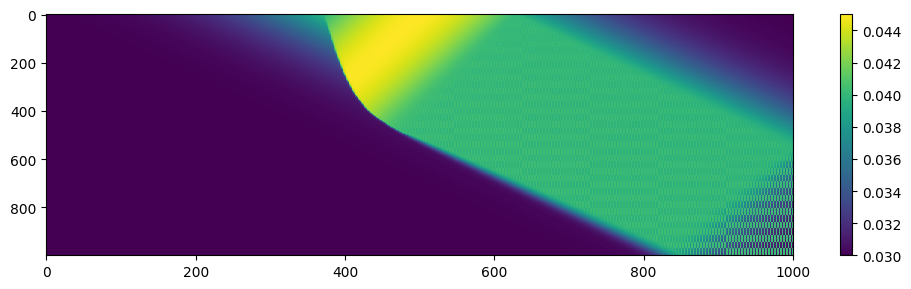

In [144]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()

# Method ii

In [145]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    b = rho[t_i,1:-1]
    b[0] += dt/(2*dx)*dQ_e(rho[t_i, 0])*rho[t_i+1, 0]
    b[-1] -= dt/(2*dx)*dQ_e(rho[t_i, -1])* rho[t_i+1, -1]

    A = jnp.eye(N_x-2) + jnp.diag(dt/(2*dx)*dQ_e(rho[t_i,2:-1]), k=1 ) + jnp.diag(-dt/(2*dx)*dQ_e(rho[t_i,1:-2]), k=-1)
    rho[t_i+1, 1:-1] = jnp.linalg.inv(A) @ b

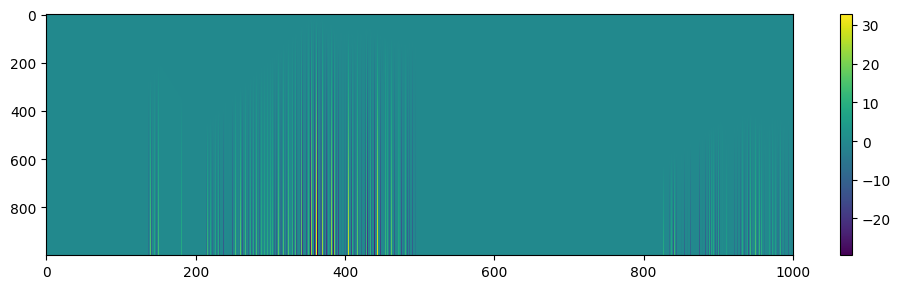

In [146]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()

# Method iii

$$
\frac{\rho_k (t_{i+1}) - \rho_k(t_i)}{\Delta t} + \frac{dQ_e(\rho_k(t_i))}{d\rho}\frac{\rho_{k}(t_i) - \rho_{k-1}(t_i)}{\Delta x} = 0
$$

In [92]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    rho[t_i+1, 1:-1] = rho[t_i, 1:-1] - dt*dQ_e(rho[t_i, 1:-1])*(rho[t_i, 1:-1] - rho[t_i, :-2])/(dx)

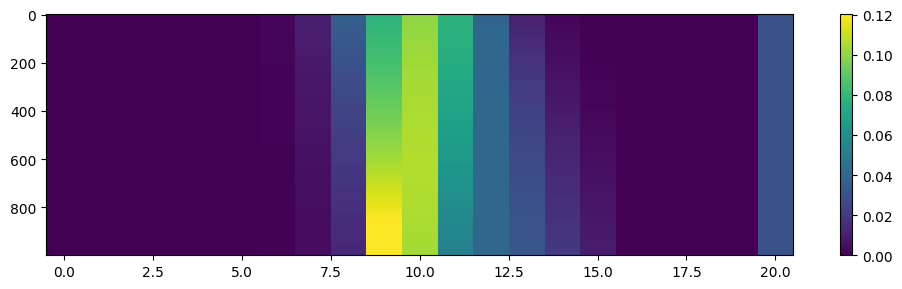

In [93]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()

# Method iv

$$
\frac{\rho_k (t_{i+1}) - \rho_k(t_i)}{\Delta t} + \frac{dQ_e(\rho_k(t_i))}{d\rho}\frac{\rho_{k}(t_i) - \rho_{k-1}(t_i)}{\Delta x} = 0
$$

In [84]:
x_lim = (0, 100)
t_lim = (0, 2.5)

dx = 0.2
dt = dx/120

x = np.linspace(*x_lim, int((x_lim[1]-x_lim[0])/dx + 1))
t = np.linspace(*t_lim, int((t_lim[1]-t_lim[0])/dt + 1))
X,T = np.meshgrid(x,t)

f = lambda u: 120*u*(1-u)

u_0t = lambda t: 0.2
u_100t = lambda t: 0.2
u_x0 = lambda x: 0.2 + 0.5*np.exp(-np.square((x-50)/30))

rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

@jax.jit
def Q_e2(u):
    return u*(1-u)

for t_i in range(N_t-1):
    rho[t_i+1, 1:-1] = 0.5*(rho[t_i,:-2] + rho[t_i,2:]) - dt/(2*dx)*(Q_e2(rho[t_i, 2:]) - Q_e2(rho[t_i, :-2]))

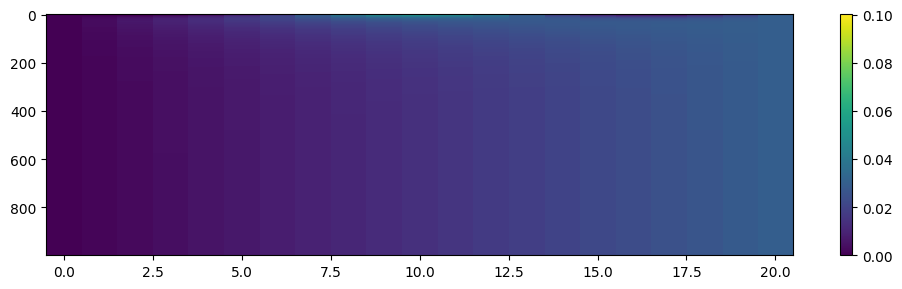

In [85]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()